This file contains the code for the following steps for the fourth strategy:
- building a Concept Lattice;
- 3 options for choosing the best concepts from lattice: the minimum number of the best by metric, random concepts, a larger number of the best by metric;
- selecting the best parameters for cross-validation for the Concept Network;
- visualization of the best Concept Network on two metrics f1 and recall.

In [1]:
# To comply with the code style
%load_ext jupyter_black

### Libraries

In [2]:
import numpy as np
import pandas as pd
import torch

# Preprocessing
from sklearn.model_selection import train_test_split

# FCA tools
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

# Model
import neural_lib62 as nl
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
)

# Visualization
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

plt.rcParams["figure.facecolor"] = (1, 1, 1, 1)

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
SEED = 42
STRATEGY_NUMBER = 4

### Dataset import

In [6]:
df_bin = pd.read_csv(f"datasets/strategy{STRATEGY_NUMBER}.csv", index_col=0)

### Preparing index for ConceptLattice

In [7]:
df_bin = df_bin.set_index(np.arange(len(df_bin)).astype(str))

### Spliting the data to train and test

In [8]:
y = df_bin["stroke"]
X = df_bin.drop(columns=["stroke"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Concept Lattice

In [9]:
def build_lattice(X_train):
    K_train = FormalContext.from_pandas(X_train)
    L = ConceptLattice.from_context(K_train, algo="Sofia", is_monotone=True)
    print(len(L))
    # Compute metrics for each formal concept
    # (assuming that an object is predicted True if it is in the extent of the concept)
    for c in L:
        y_preds = np.zeros(K_train.n_objects)
        y_preds[list(c.extent_i)] = 1
        c.measures["f1_score"] = f1_score(y_train, y_preds)
        c.measures["accuracy"] = accuracy_score(y_train, y_preds)
        c.measures["recall"] = recall_score(y_train, y_preds)
        c.measures["precision"] = precision_score(y_train, y_preds)
    return K_train, L

In [10]:
%%time

K_train, L = build_lattice(X_train)

100
CPU times: total: 1min 3s
Wall time: 1min 15s


# Best concepts selecting

In [11]:
# Select indices of the best concepts from the lattice
def select_concepts_best(L, K_train, metric):
    n_concepts = 3  # Sometimes 1 is enough for this dataset, which seems strange
    while True:
        best_concepts = list(L.measures[metric].argsort()[::-1][:n_concepts])
        covered_indices = {g_i for c in L[best_concepts] for g_i in c.extent_i}
        if len(covered_indices) == K_train.n_objects:
            break
        n_concepts += 1
    return best_concepts

In [12]:
# Select indices of the (minimal+threshold) best concepts from the lattice
def select_concepts_more_best(L, K_train, threshold, metric):
    n_concepts = len(select_concepts_best(L, K_train, metric))
    best_concepts = list(L.measures[metric].argsort()[::-1][: (n_concepts + threshold)])
    return best_concepts

In [13]:
# Select indices of random concepts from the lattice
def select_concepts_random(L, K_train, metric):
    n_concepts = 3
    while True:
        best_concepts = list(
            np.random.choice(
                list(L.measures[metric].argsort()[::-1]), size=n_concepts, replace=False
            )
        )
        covered_indices = {g_i for c in L[best_concepts] for g_i in c.extent_i}
        if len(covered_indices) == K_train.n_objects:
            break
        n_concepts += 1
    return best_concepts

In [14]:
best_concepts_dict = {"f1_score": {}, "recall": {}}
for metric in ["f1_score", "recall"]:
    best_concepts_dict[metric]["best"] = select_concepts_best(L, K_train, metric)
    best_concepts_dict[metric]["more_best"] = select_concepts_more_best(
        L, K_train, 15, metric
    )
    best_concepts_dict[metric]["random"] = select_concepts_random(L, K_train, metric)

# Neural network

In [15]:
# Base method for neural network evaluate
def neural_network_base(L, best_concepts, n_epoch, func_nl):
    cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
    cn.fit(X_train, y_train, n_epochs=n_epoch, nonlinearity=func_nl)

    # predicting
    y_pred = cn.predict(X_test)[1]
    # y_proba = cn.predict_proba(X_test).detach().numpy()

    # metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred[1])

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("----------------\n")

    return cn, recall, f1

In [16]:
# cross val score for ConceptNetwork
def neural_network(L, best_concepts, n_epoch, func_nl, num_folds=3):
    cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

    f1s, recalls = [], []
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

    for train_index, test_index in kf.split(X_train, y_train):
        x_train_curr, x_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_train_curr, y_val = y_train[train_index], y_train[test_index]

        cn.fit(x_train_curr, y_train_curr, n_epochs=n_epoch, nonlinearity=func_nl)

        y_pred = cn.predict(x_val)[1]
        recalls.append(recall_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))

    f1 = np.mean(np.array(f1s))
    recall = np.mean(np.array(recalls))

    print(f"f1 mean: {f1}")
    print(f"recall mean: {recall}")
    print("----------------\n")

    return cn, recall, f1

In [17]:
# GridSearchCV for ConceptNetwork
def crossval_hyperparameter_tuning(metric="f1_score"):
    best_n = 0
    best_nnl = None
    best_type = "best"
    best_estimator = None
    best_metric_value = 0.0
    idx = 0
    metrics = {"n_epoch": [], "nnl": [], "bc_type": [], "f1": [], "recall": []}
    for n_epoch in n_epochs:
        for nnl in nonlinearities:
            for bc_type, bc in best_concepts_dict[metric].items():
                idx += 1
                print(f"Experiment {idx}")
                print(f"Parameters: n_epoch={n_epoch}, nnl={nnl}, bc_type={bc_type}")
                cn, recall, f1 = neural_network(L, bc, n_epoch, nnl)
                if metric == "recall":
                    check = recall
                else:
                    check = f1
                if check > best_metric_value:
                    best_metric_value = recall
                    best_n = n_epoch
                    best_nnl = nnl
                    best_type = bc_type
                    best_estimator = cn
                metrics["n_epoch"].append(n_epoch)
                metrics["nnl"].append(nnl)
                metrics["bc_type"].append(bc_type)
                metrics["f1"].append(f1)
                metrics["recall"].append(recall)
    return best_estimator, best_n, best_nnl, best_type, metrics

## Parameter tuning

In [18]:
n_epochs = [2000, 5000, 7000]
nonlinearities = [torch.nn.ReLU, torch.nn.Tanh, torch.nn.Sigmoid]

In [19]:
# Zero at a small value of n_epoch indicates an underfitting due to an ambulance of classes,
# and on large ones about overfitting (the model becomes a constant classifier)

### Recall

In [20]:
%%time
(
    best_estimator_recall,
    best_n_recall,
    best_nnl_recall,
    best_type_recall,
    metrics_recall,
) = crossval_hyperparameter_tuning(metric="recall")

Experiment 1
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.ReLU'>, bc_type=best
f1 mean: 0.405607476635514
recall mean: 0.3888888888888889
----------------

Experiment 2
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.ReLU'>, bc_type=more_best
f1 mean: 0.0
recall mean: 0.0
----------------

Experiment 3
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.ReLU'>, bc_type=random
f1 mean: 0.21383647798742136
recall mean: 0.20987654320987656
----------------

Experiment 4
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.Tanh'>, bc_type=best
f1 mean: 0.6160531971714724
recall mean: 0.5802469135802469
----------------

Experiment 5
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.Tanh'>, bc_type=more_best
f1 mean: 0.6061475308489329
recall mean: 0.5740740740740741
----------------

Experiment 6
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.Tanh'>, bc_type=random
f1 mean: 0.62378929481733

In [21]:
print(f"Best parameters for {metric}:")
print()
print(f"n_epoch={best_n_recall}")
print(f"nonlinearity={best_nnl_recall}")
print(f"best concepts selecting type={best_type_recall}")
print()
y_pred_recall = best_estimator_recall.predict(X_test)[1]
print(classification_report(y_test, y_pred_recall))
recall = recall_score(y_test, y_pred_recall)
f1 = f1_score(y_test, y_pred_recall)
print(f"Recall: {recall}")
print(f"F1: {f1}")

Best parameters for recall:

n_epoch=2000
nonlinearity=<class 'torch.nn.modules.activation.Tanh'>
best concepts selecting type=random

              precision    recall  f1-score   support

           0       0.79      0.82      0.80        95
           1       0.60      0.55      0.58        47

    accuracy                           0.73       142
   macro avg       0.70      0.69      0.69       142
weighted avg       0.73      0.73      0.73       142

Recall: 0.5531914893617021
F1: 0.5777777777777777


### F1-score

In [22]:
%%time
best_estimator_f1, best_n_f1, best_nnl_f1, best_type_f1, metrics_f1 = (
    crossval_hyperparameter_tuning()
)

Experiment 1
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.ReLU'>, bc_type=best
f1 mean: 0.0
recall mean: 0.0
----------------

Experiment 2
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.ReLU'>, bc_type=more_best
f1 mean: 0.0
recall mean: 0.0
----------------

Experiment 3
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.ReLU'>, bc_type=random
f1 mean: 0.5947092220590985
recall mean: 0.5555555555555556
----------------

Experiment 4
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.Tanh'>, bc_type=best
f1 mean: 0.5867056935133604
recall mean: 0.5370370370370371
----------------

Experiment 5
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.Tanh'>, bc_type=more_best
f1 mean: 0.17117117117117117
recall mean: 0.11728395061728396
----------------

Experiment 6
Parameters: n_epoch=2000, nnl=<class 'torch.nn.modules.activation.Tanh'>, bc_type=random
f1 mean: 0.6062651185292695
recall mean: 0.56172839506

In [23]:
print(f"Best parameters for {'f1'}:")
print()
print(f"n_epoch={best_n_f1}")
print(f"nonlinearity={best_nnl_f1}")
print(f"best concepts selecting type={best_type_f1}")
print()
y_pred_f1 = best_estimator_f1.predict(X_test)[1]
print(classification_report(y_test, y_pred_f1))
recall = recall_score(y_test, y_pred_f1)
f1 = f1_score(y_test, y_pred_f1)
print(f"Recall: {recall}")
print(f"F1: {f1}")

Best parameters for f1:

n_epoch=5000
nonlinearity=<class 'torch.nn.modules.activation.ReLU'>
best concepts selecting type=random

              precision    recall  f1-score   support

           0       0.79      0.80      0.80        95
           1       0.59      0.57      0.58        47

    accuracy                           0.73       142
   macro avg       0.69      0.69      0.69       142
weighted avg       0.72      0.73      0.72       142

Recall: 0.574468085106383
F1: 0.5806451612903226


# Visualization

### Lattice visualization

In [24]:
def visualize_lattice(strategy_number, L):
    fig, ax = plt.subplots(figsize=(20, 20))
    vsl = LineVizNx()
    vsl.draw_concept_lattice(
        L,
        ax=ax,
        flg_node_indices=True,
        flg_new_intent_count_prefix=False,
        flg_new_extent_count_prefix=False,
    )

    plt.tight_layout()
    plt.savefig(f"visualization/lattice_for_{strategy_number}_strategy.png")
    plt.show()

Please, modify the ``pos`` dictionary parameter manually. You can obtain the default ``pos`` via Mover.initialize_pos(...) function.

The problematic edges and nodes (in the form of {edge: overlapped nodes indexes}) are:
{(7, 19): frozenset({25}), (76, 97): frozenset({93})}


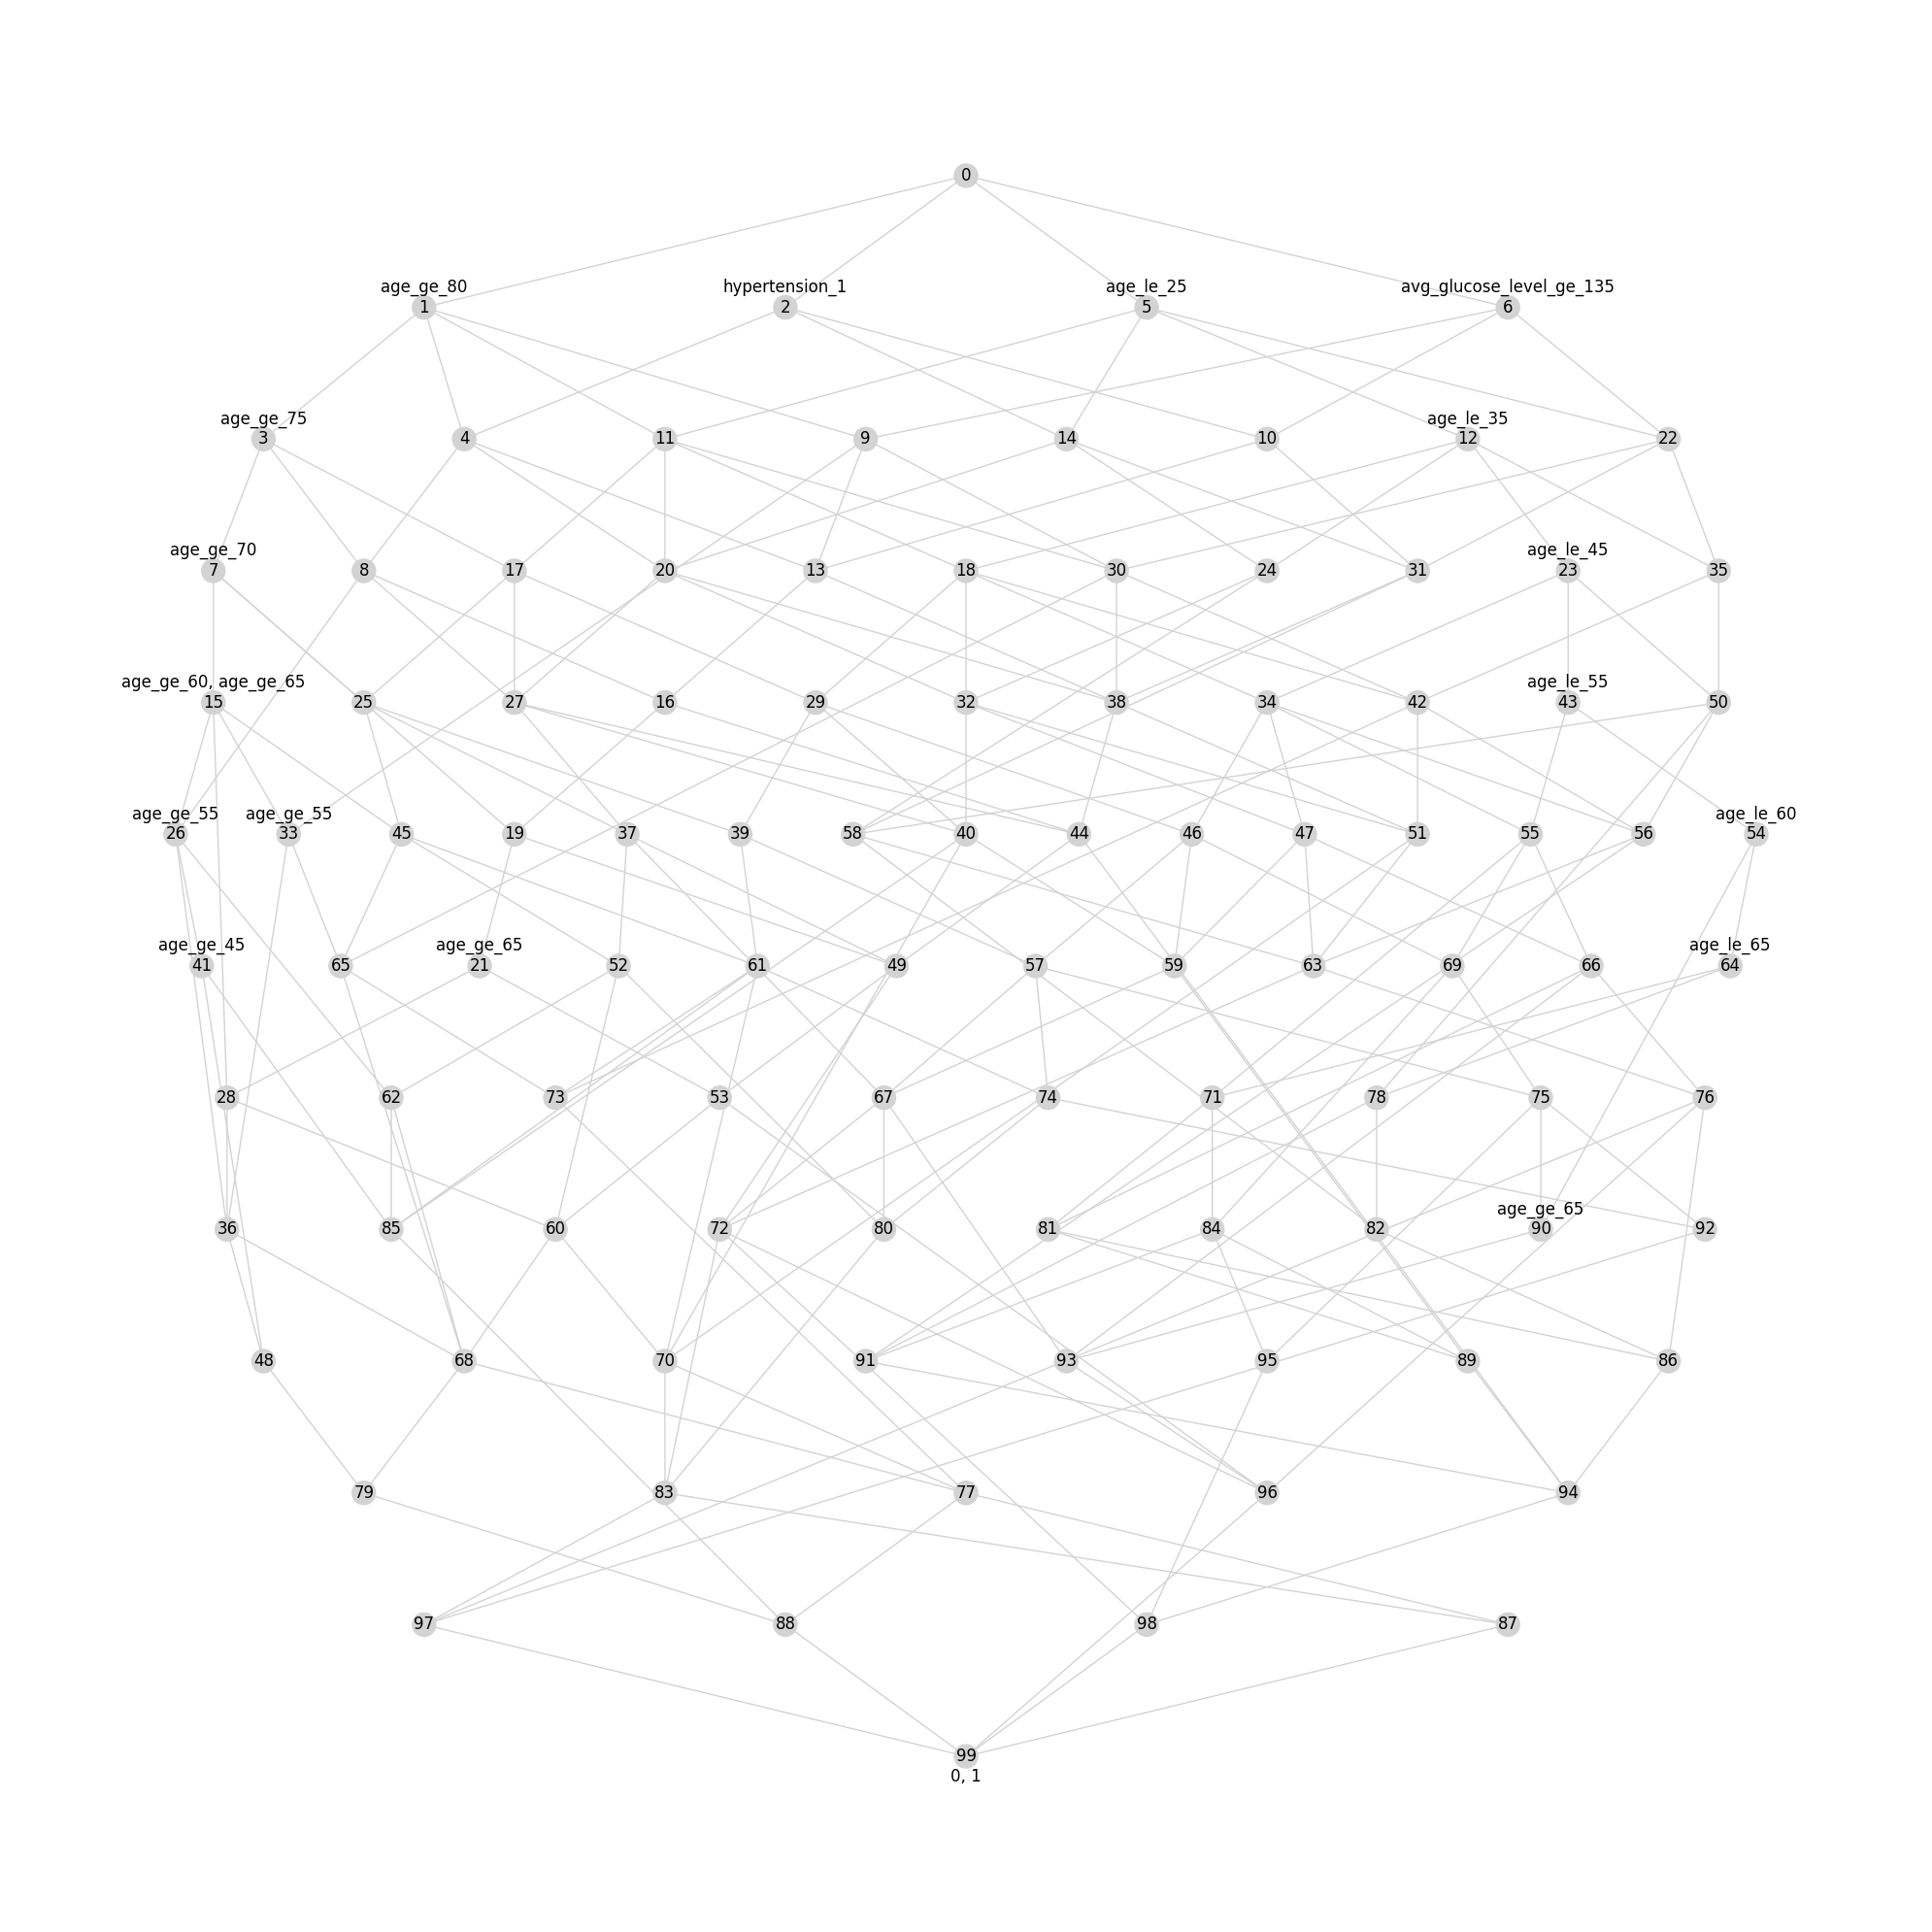

In [25]:
visualize_lattice(STRATEGY_NUMBER, L)

### Unfitted network 

In [26]:
def visualize_unfitted_network(strategy_number, cn, n_concepts, metric):
    # Setup visuzalier for the architecture
    vis = LineVizNx(
        node_label_font_size=14,
        node_label_func=lambda el_i, P: nl.neuron_label_func(
            el_i, P, set(cn.attributes)
        )
        + "\n\n",
    )

    descr = {"smokes", "bmi_ge_30", "age_ge_45"}
    traced = cn.trace_description(descr, include_targets=False)

    fig, ax = plt.subplots(figsize=(40, 8))
    lst = ["\n"] * len(set(cn.attributes))
    for i in range(0, len(set(cn.attributes)), 2):
        lst[i] += "\n"

    vis.draw_poset(
        cn.poset,
        ax=ax,
        flg_node_indices=False,
        node_label_func=lambda el_i, P: nl.neuron_label_func(
            el_i, P, set(cn.attributes), only_new_attrs=True
        )
        + f"\n\n\n{'\n\n\n' * (el_i % 3)}",  # "\n\n",
        node_color=[
            "darkblue" if el_i in traced else "lightgray"
            for el_i in range(len(cn.poset))
        ],
        node_size=100,
        node_label_font_size=8,
    )
    plt.title(
        f"NN based on "
        + str(n_concepts)
        + " best concepts from monotone concept lattice",
        loc="left",
        x=0.05,
        size=24,
    )

    plt.text(
        max(vis.mover.posx),
        min(vis.mover.posy) - 0.3,
        f"*Blue neurons are the ones activated by description {descr}",
        fontsize=14,
        ha="right",
        color="dimgray",
    )

    plt.subplots_adjust()
    plt.tight_layout()
    plt.savefig(f"visualization/unfitted_for_strategy_{strategy_number}_{metric}.png")
    plt.show()

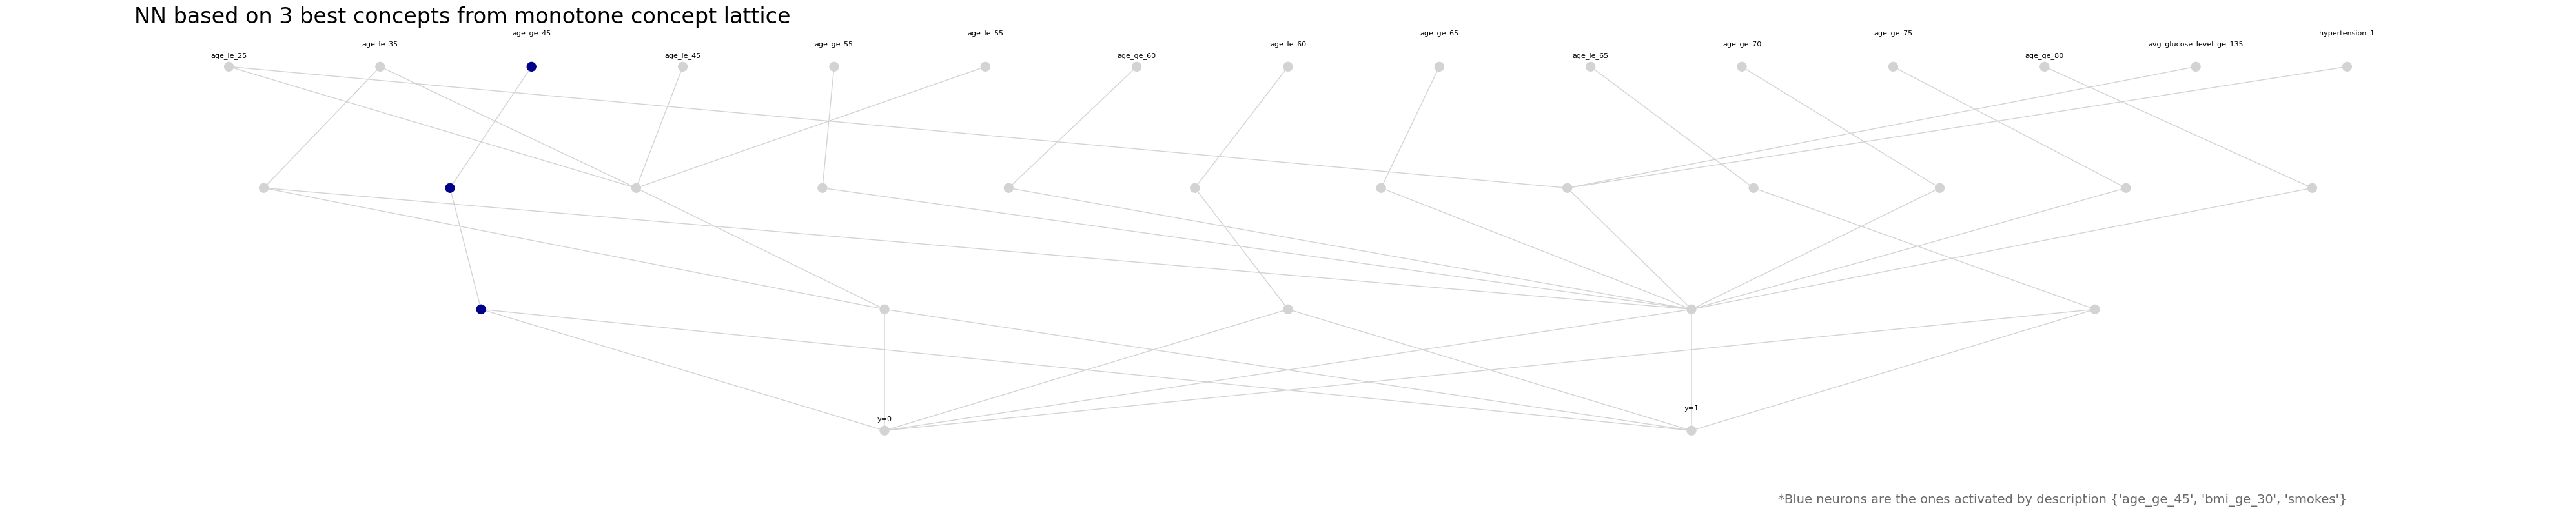

In [27]:
n_concepts = len(best_concepts_dict["f1_score"][best_type_f1])
visualize_unfitted_network(STRATEGY_NUMBER, best_estimator_f1, n_concepts, "f1")

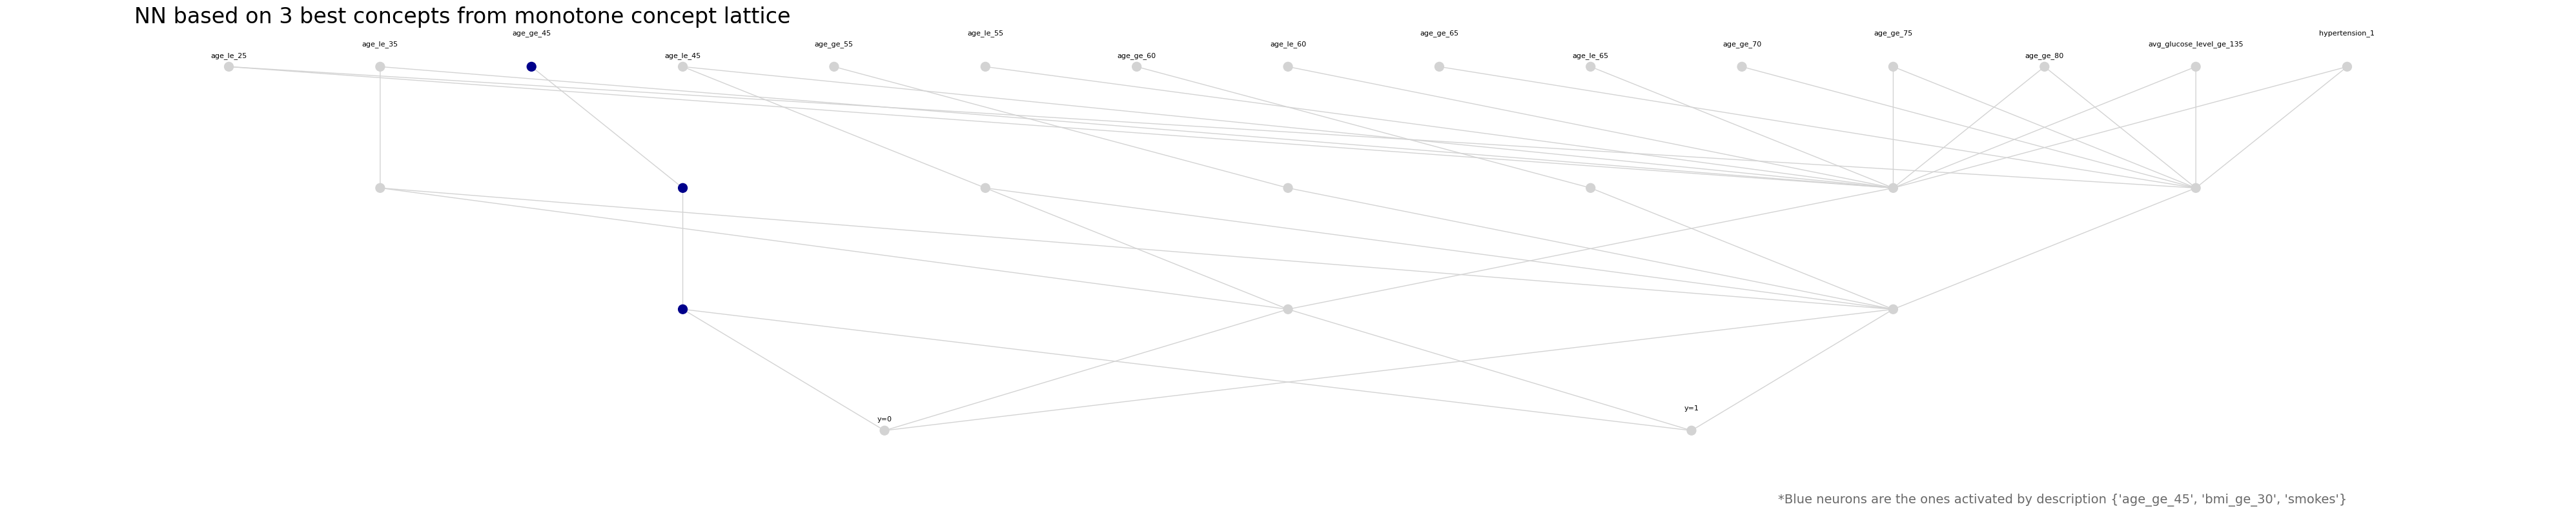

In [28]:
n_concepts = len(best_concepts_dict["recall"][best_type_recall])
visualize_unfitted_network(STRATEGY_NUMBER, best_estimator_recall, n_concepts, "recall")

### Fitted network

In [29]:
def fitted_visualization(strategy_number, cn, metric):
    vis = LineVizNx(
        node_label_font_size=14,
        node_label_func=lambda el_i, P: nl.neuron_label_func(
            el_i, P, set(cn.attributes)
        )
        + "\n\n",
    )
    edge_weights = cn.edge_weights_from_network()

    fig, ax = plt.subplots(figsize=(45, 20))

    vis.draw_poset(
        cn.poset,
        ax=ax,
        flg_node_indices=False,
        node_label_func=lambda el_i, P: nl.neuron_label_func(
            el_i, P, set(cn.attributes), only_new_attrs=True
        )
        + f"\n\n\n{'\n\n\n' * (el_i % 4)}",  # "\n\n",
        edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
        edge_cmap=plt.cm.RdBu,
    )
    nx.draw_networkx_edge_labels(
        cn.poset.to_networkx(),
        vis.mover.pos,
        {k: f"{v:.1f}" for k, v in edge_weights.items()},
        label_pos=0.7,
    )

    plt.title("Neural network with fitted edge weights", size=24, x=0.05, loc="left")
    plt.tight_layout()
    plt.subplots_adjust()
    plt.savefig(
        f"visualization/fitted_network_for_strategy_{strategy_number}_{metric}.png"
    )
    plt.show()

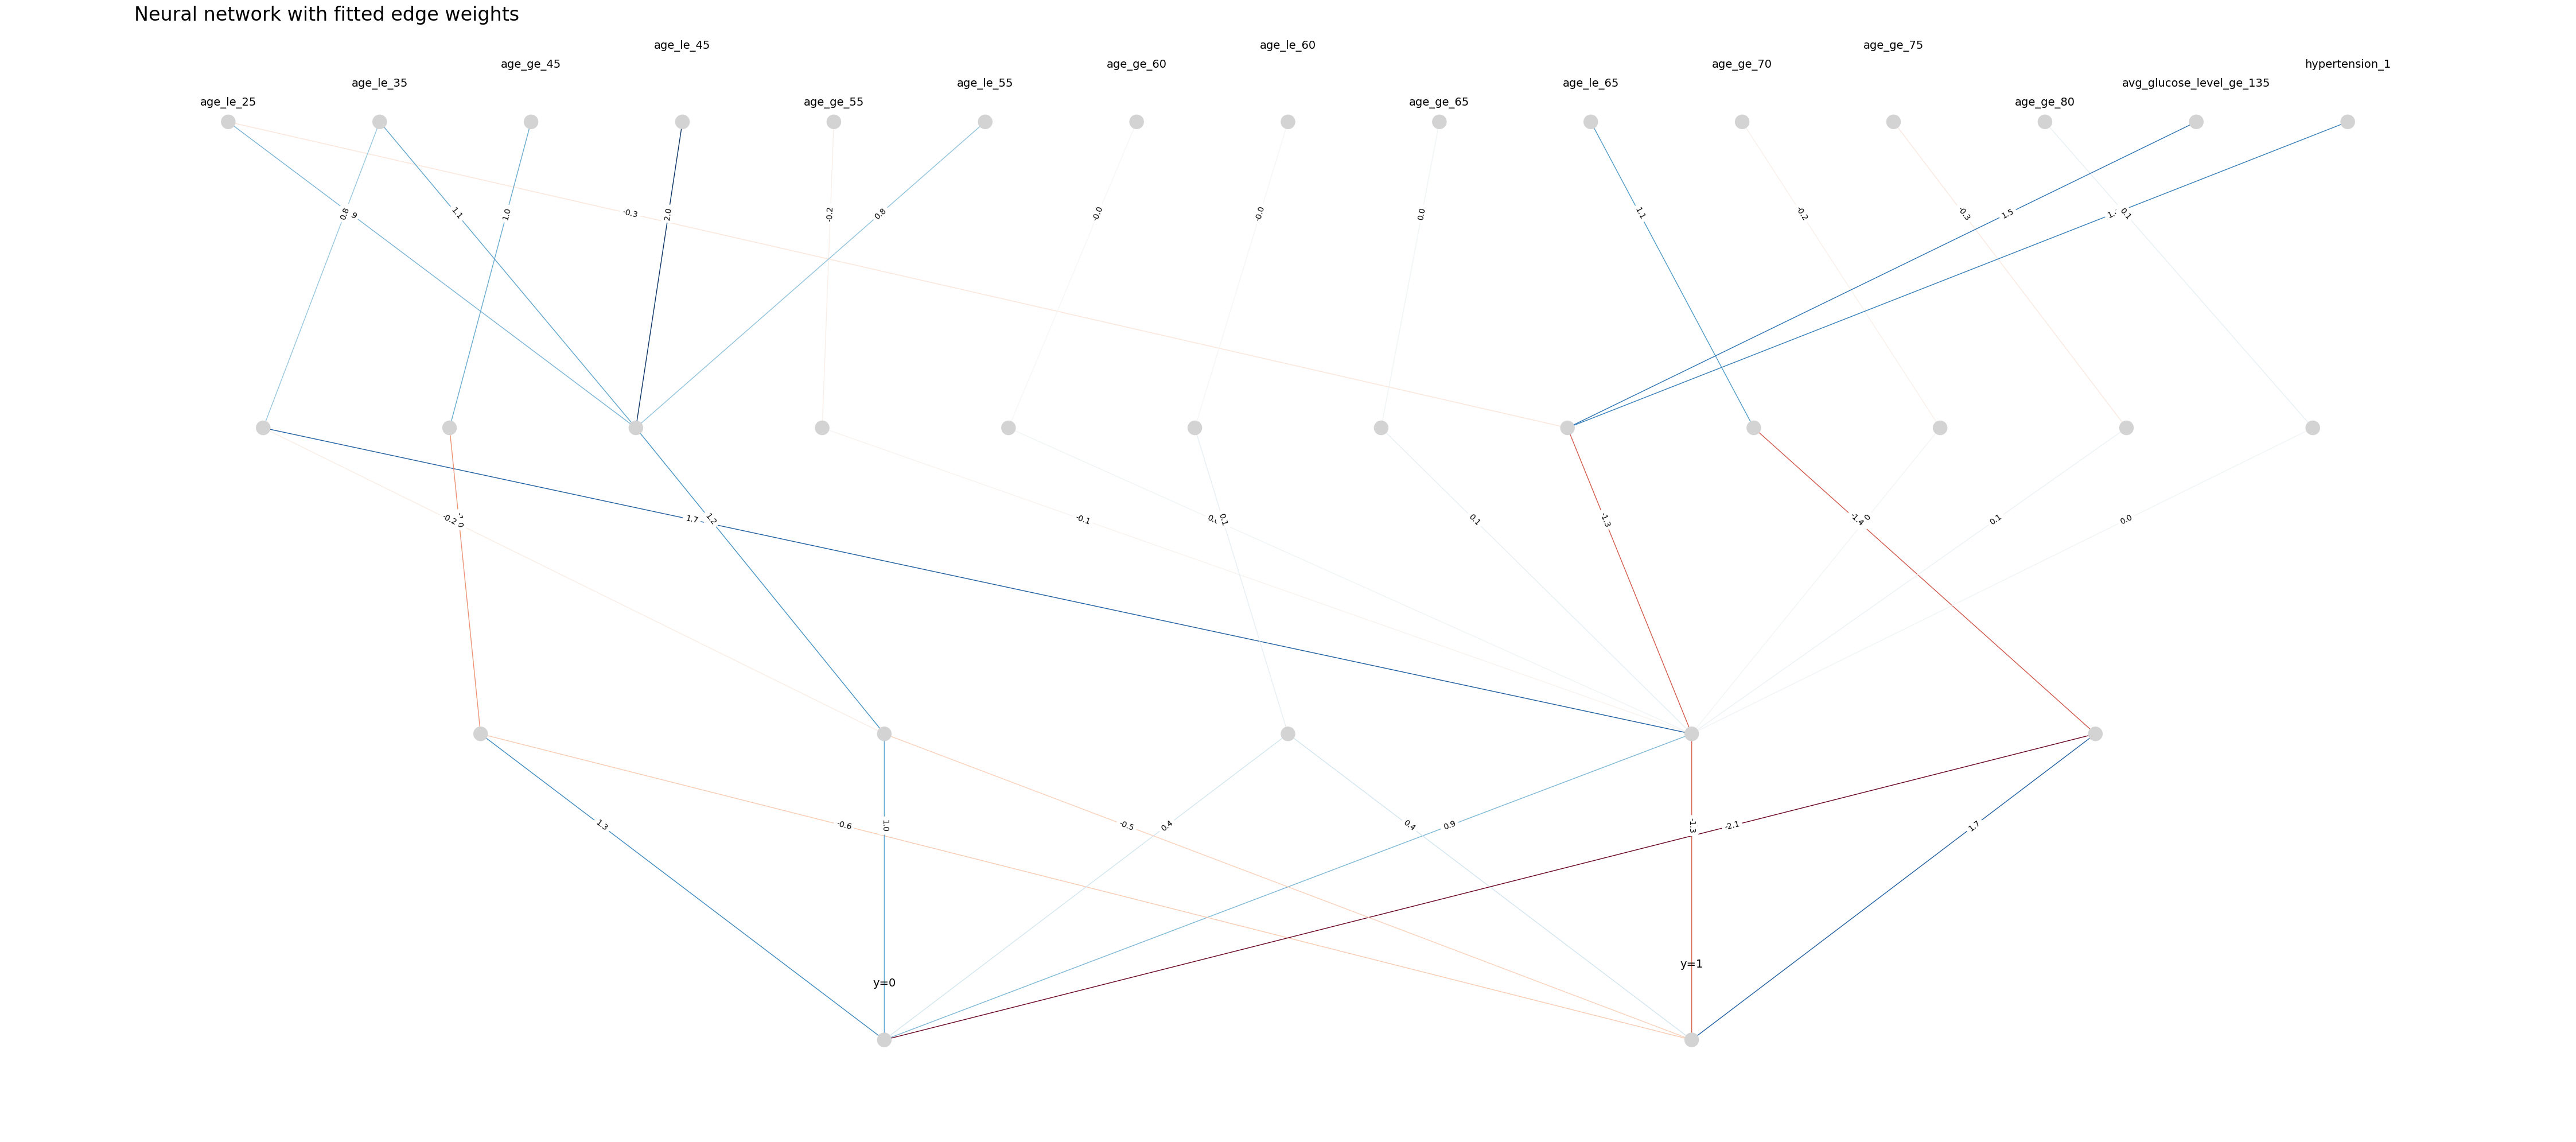

In [30]:
fitted_visualization(STRATEGY_NUMBER, best_estimator_f1, "f1")

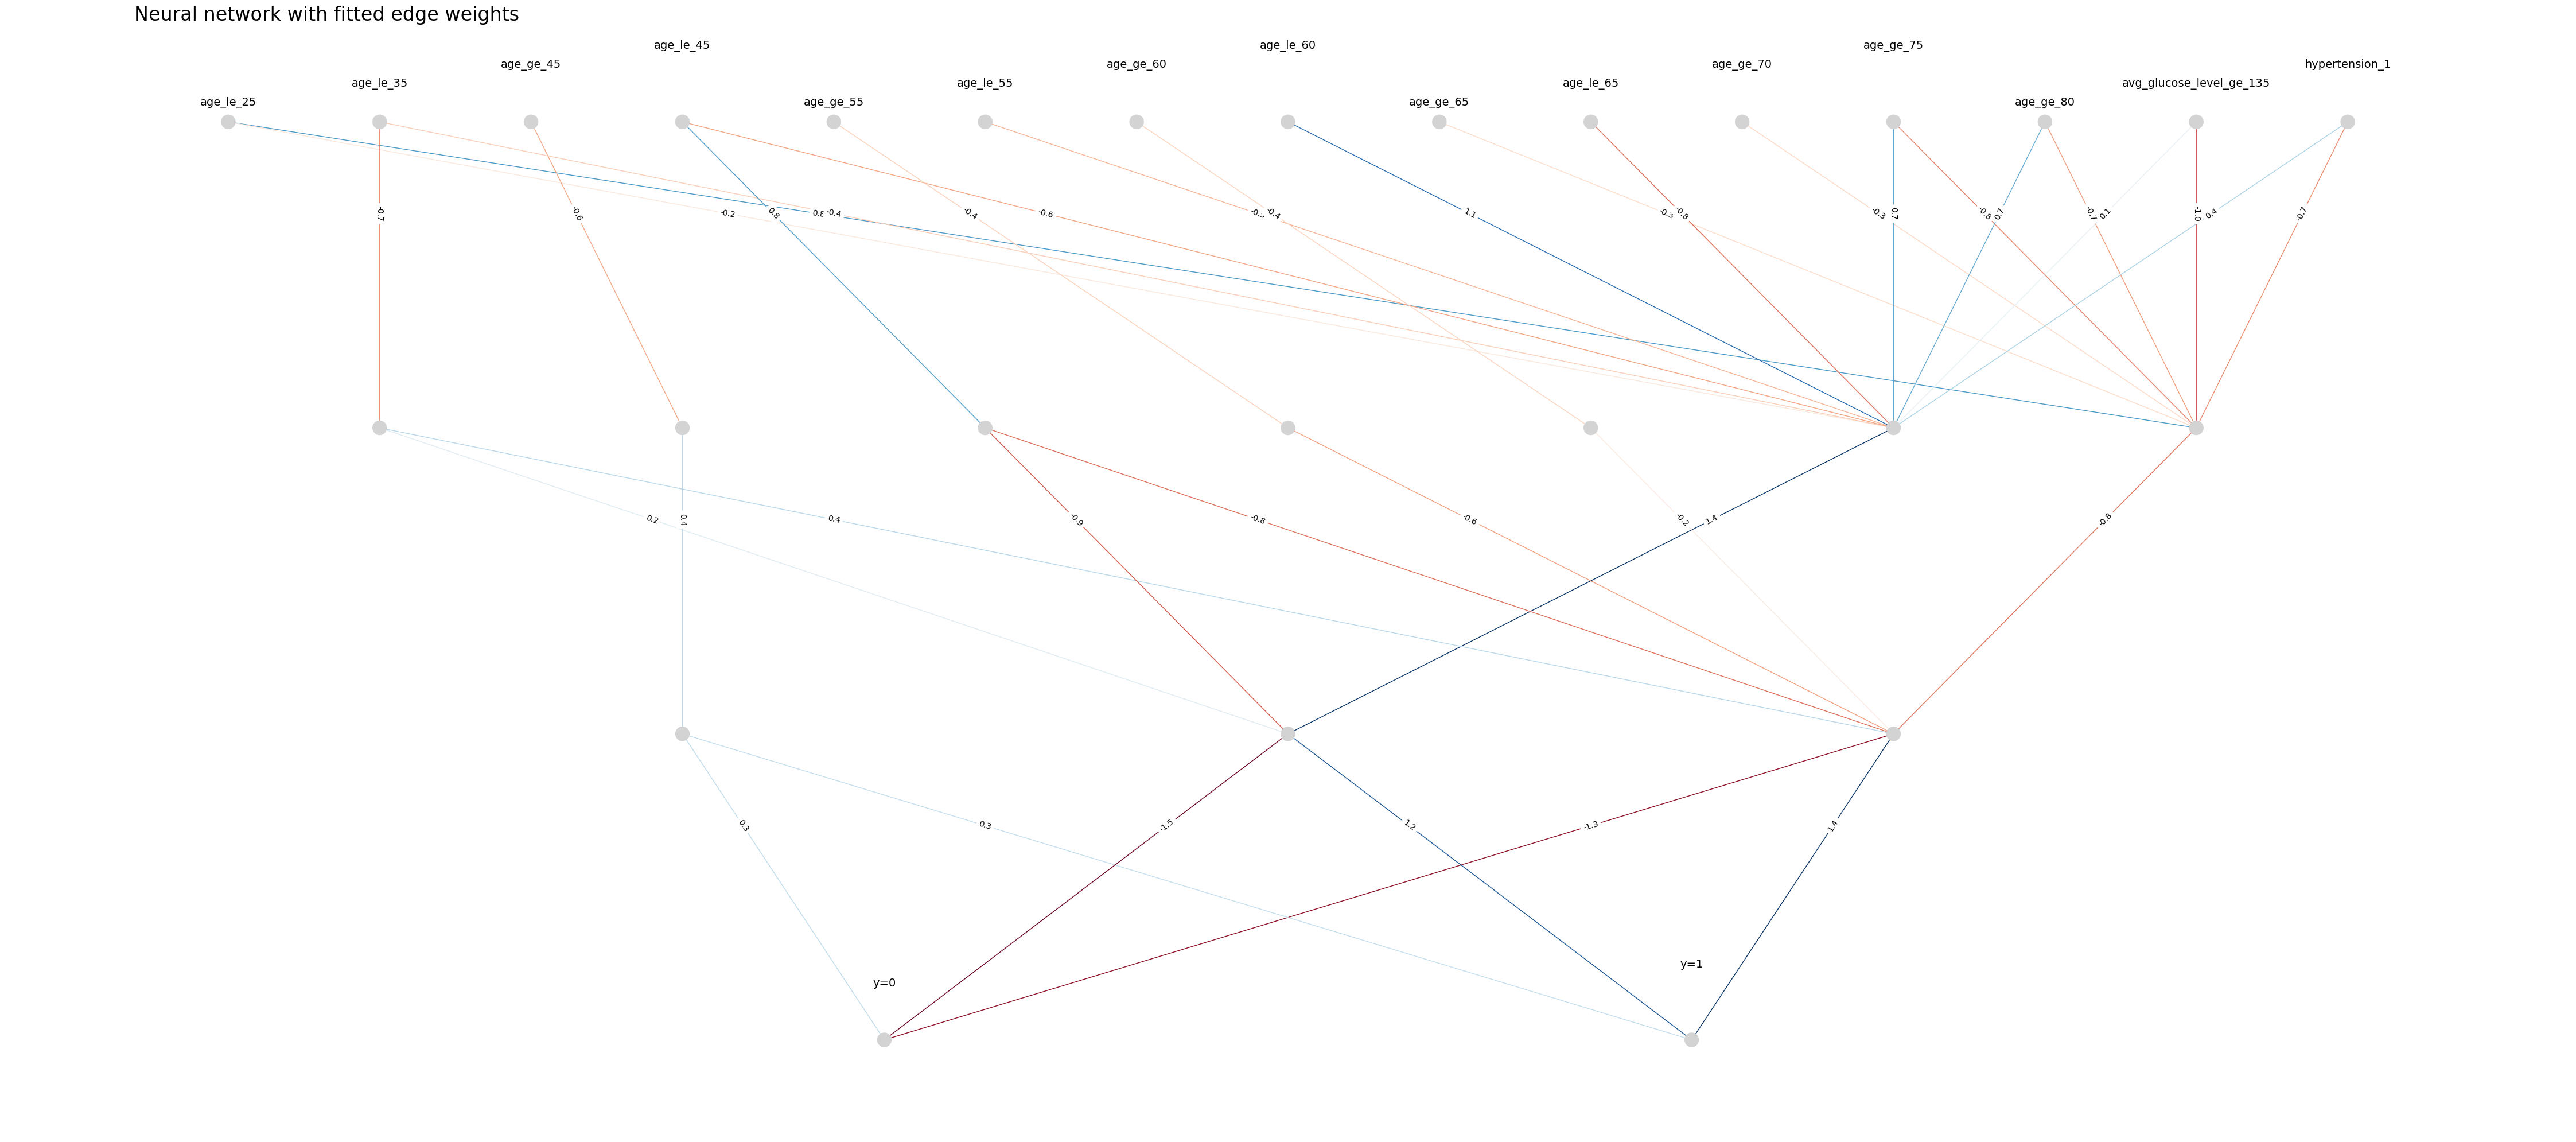

In [31]:
fitted_visualization(STRATEGY_NUMBER, best_estimator_recall, "recall")

## Dependencies

In [32]:
r = pd.DataFrame(metrics_recall)
f = pd.DataFrame(metrics_f1)
r.to_csv(f"datasets/m_rec_{STRATEGY_NUMBER}.csv")
f.to_csv(f"datasets/m_f_{STRATEGY_NUMBER}.csv")

In [33]:
r = pd.read_csv(f"datasets/m_rec_{STRATEGY_NUMBER}.csv", index_col=0)
f = pd.read_csv(f"datasets/m_f_{STRATEGY_NUMBER}.csv", index_col=0)

### Nonlinearity function influence

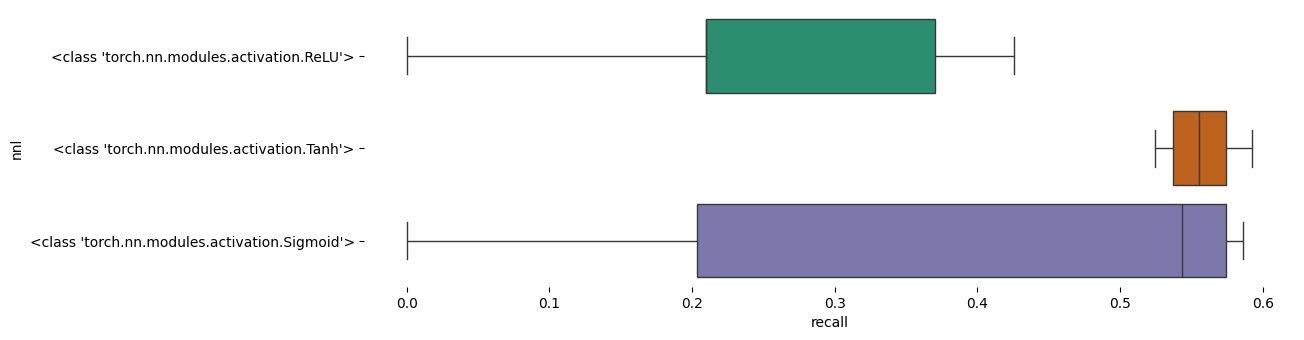

In [34]:
figsize = (12, 1.2 * len(r["nnl"].unique()))
plt.figure(figsize=figsize)
sns.boxplot(r, x="recall", y="nnl", palette="Dark2")
sns.despine(top=True, right=True, bottom=True, left=True)

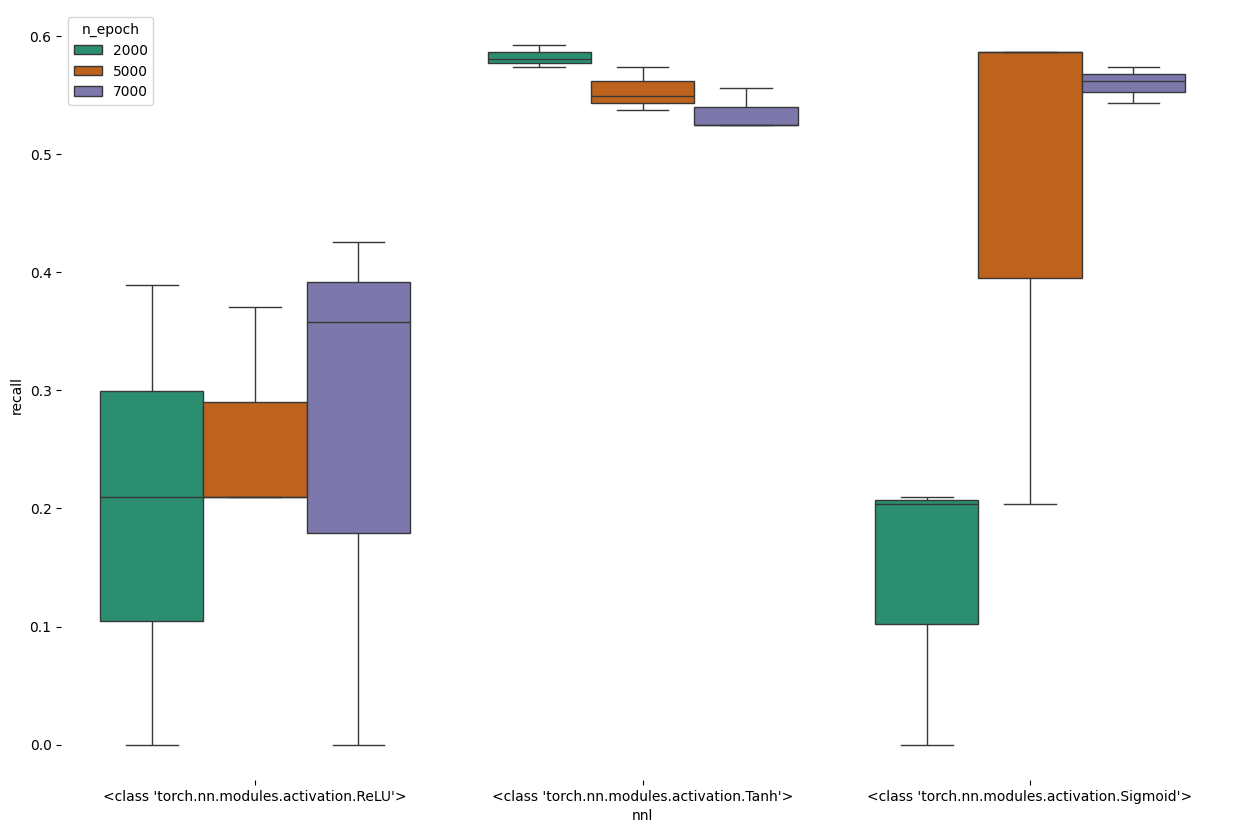

In [35]:
figsize = (15, 10)
plt.figure(figsize=figsize)
sns.boxplot(r, x="nnl", y="recall", hue="n_epoch", palette="Dark2")
sns.despine(top=True, right=True, bottom=True, left=True)

### Best concepts way influence

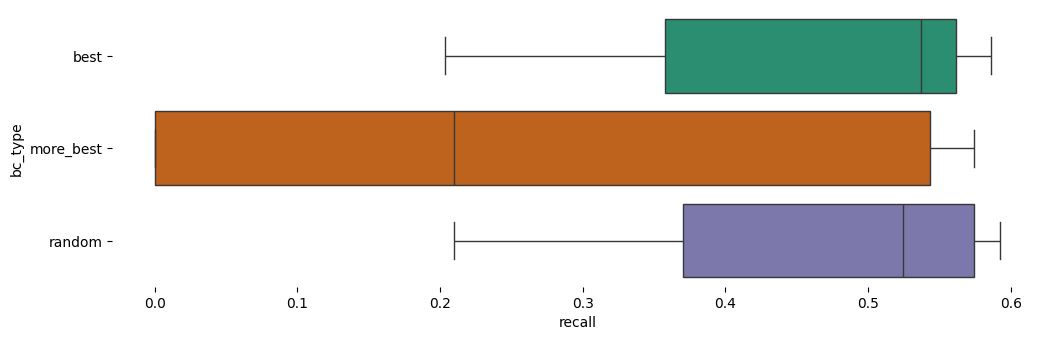

In [36]:
figsize = (12, 1.2 * len(r["bc_type"].unique()))
plt.figure(figsize=figsize)
sns.boxplot(r, x="recall", y="bc_type", palette="Dark2")
sns.despine(top=True, right=True, bottom=True, left=True)

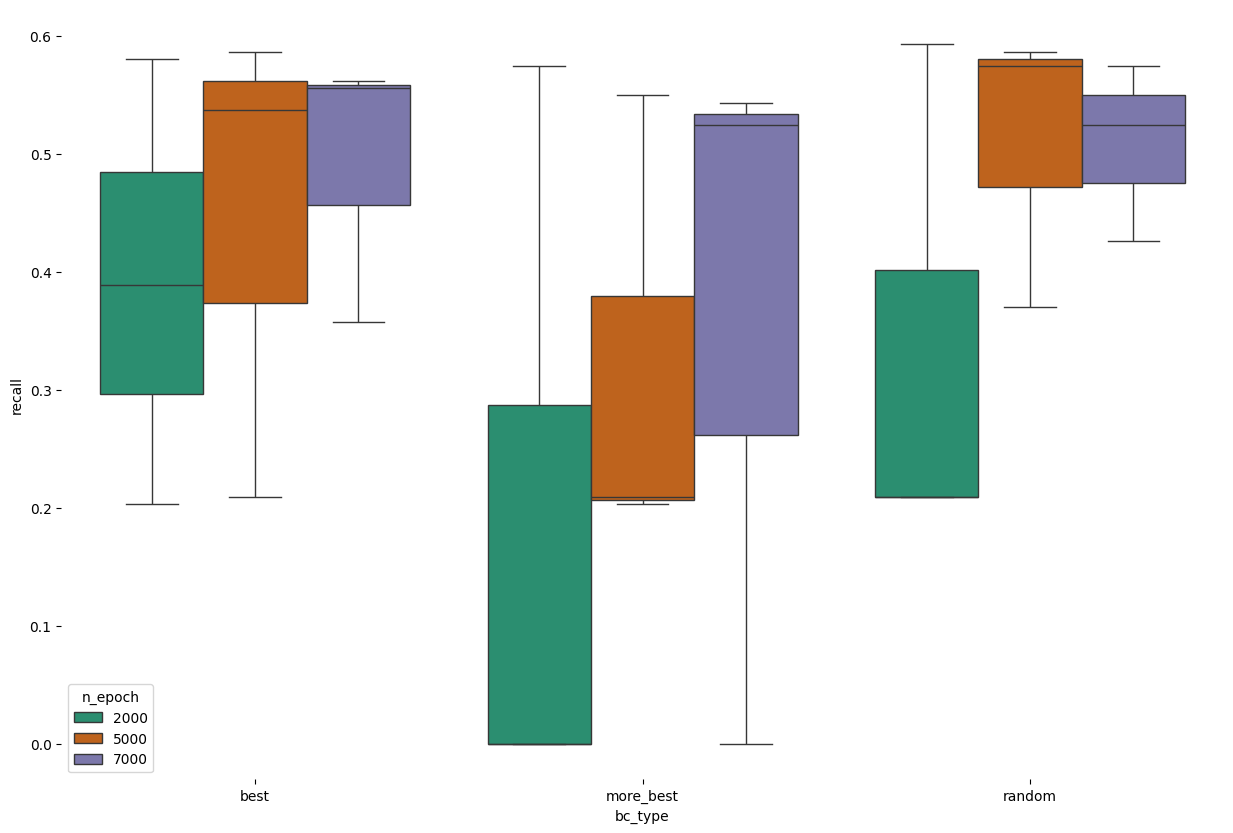

In [37]:
figsize = (15, 10)
plt.figure(figsize=figsize)
sns.boxplot(r, x="bc_type", y="recall", hue="n_epoch", palette="Dark2")
sns.despine(top=True, right=True, bottom=True, left=True)

### Best concepts way with nonlinearity dependence

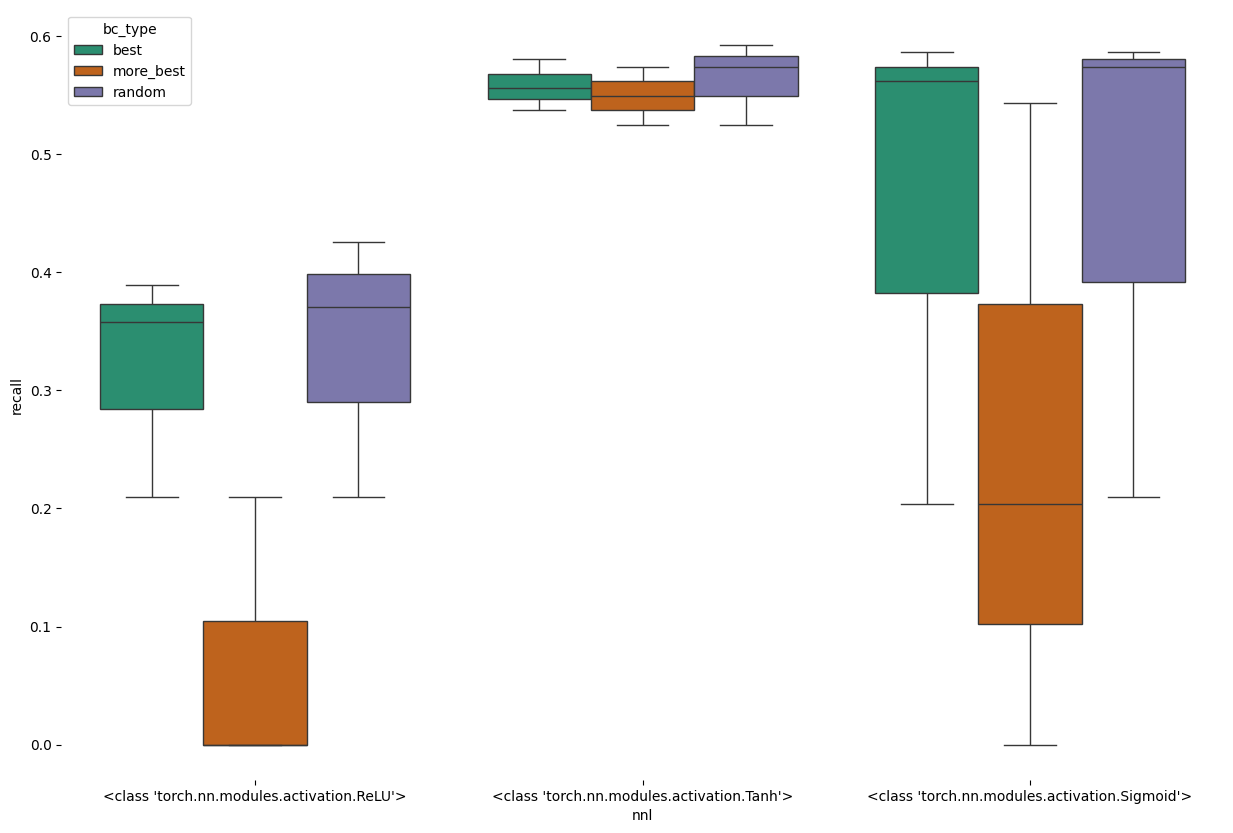

In [38]:
figsize = (15, 10)
plt.figure(figsize=figsize)
sns.boxplot(r, x="nnl", y="recall", hue="bc_type", palette="Dark2")
sns.despine(top=True, right=True, bottom=True, left=True)